In [26]:
# LOADING REQUIRED LIBRARIES
# Data Visualization libraries
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt

# %#matplotlib inline

# Encoders
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# Importing train, test split library
from sklearn.model_selection import train_test_split

# Metrices import
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, roc_curve, make_scorer
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.feature_selection import SelectFromModel
from numpy import sort

# Accuracy Check
from sklearn.model_selection import cross_val_score

# Importing custom packages
from sklearn.base import TransformerMixin

# Importing ML Model packages
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold

# from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Hyperopt
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials, space_eval
from hyperopt.pyll.base import scope

# For proper display of all columns
from IPython.display import display

pd.options.display.max_columns = None

# Import warnings
import warnings

warnings.filterwarnings("ignore")

import statsmodels.api as sm

In [27]:
def calculate_count_and_proportion_per_label(df, target_variable):
    """Calculates the count and proportion per label in a Pandas DataFrame with a binary target variable.

    Args:
      df: A Pandas DataFrame.
      target_variable: The name of the binary target variable in the DataFrame.

    Returns:
      A Pandas Series containing the count and proportion per label.
    """

    # Create a new Series containing the count per label.
    count_per_label = df[target_variable].value_counts()

    # Calculate the proportion per label.
    proportion_per_label = count_per_label / count_per_label.sum()

    # Return the Series containing the count and proportion per label.
    return pd.DataFrame(
        {
            "count_per_label": count_per_label,
            "proportion_per_label": proportion_per_label,
        }
    )



In [28]:
folder_path = "../../data"
file_path = os.path.join(folder_path, "data_baseline.csv")
data_baseline = pd.read_csv(file_path)

# Train Test Split

In [29]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data_baseline.drop(["age_cat", "two_year_recid"], axis=1),
    data_baseline["two_year_recid"],
    test_size=0.2,
    random_state=1000,
    stratify=data_baseline["two_year_recid"],
)
# y_train.reset_index(drop = True, inplace = True)
# y_test.reset_index(drop = True, inplace = True)

# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the training data using the scaler
X_train_scaled = scaler.fit_transform(X_train.drop(["id"], axis=1))
X_train_scaled = pd.DataFrame(
    X_train_scaled, columns=X_train.drop(["id"], axis=1).columns, index=X_train.index
)

# Transform the testing data using the same scaler
X_test_scaled = scaler.transform(X_test.drop(["id"], axis=1))
X_test_scaled = pd.DataFrame(
    X_test_scaled, columns=X_train.drop(["id"], axis=1).columns, index=X_test.index
)

# Model

In [30]:
# building the model and fitting the data
log_reg = sm.Logit(y_train, X_train_scaled, random_state = 1000).fit()
#results = log_reg.fit()

         Current function value: 0.568703
         Iterations: 35


In [31]:
# printing the summary table
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:         two_year_recid   No. Observations:                 5748
Model:                          Logit   Df Residuals:                     5729
Method:                           MLE   Df Model:                           18
Date:                Thu, 30 Nov 2023   Pseudo R-squ.:                  0.1736
Time:                        00:12:48   Log-Likelihood:                -3268.9
converged:                      False   LL-Null:                       -3955.7
Covariance Type:            nonrobust   LLR p-value:                6.628e-281
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
sex                             0.1047      0.030      3.446      0.001       0.045       0.164
age                            -0.3930      0.038    -10.273      0.000      -0.

Classification Report for Logistic Regression model on test set

              precision    recall  f1-score   support

           0       0.73      0.72      0.72       790
           1       0.66      0.67      0.67       647

    accuracy                           0.70      1437
   macro avg       0.70      0.70      0.70      1437
weighted avg       0.70      0.70      0.70      1437


 accuracy: 0.697981906750174 & F1_Score: 0.6951293673202819 



<AxesSubplot:>

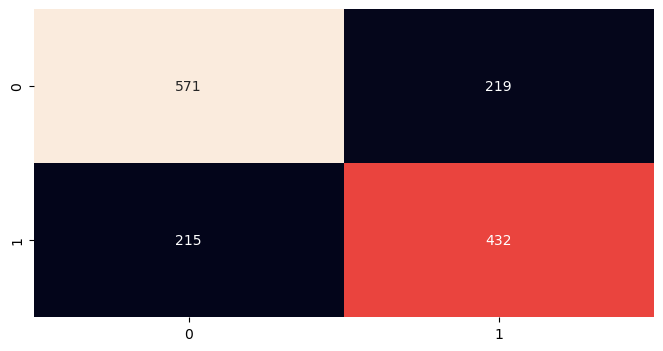

In [32]:
# Performance on test
model_name = 'Logistic Regression'
y_pred_prob = log_reg.predict(X_test_scaled)
y_pred_test = (y_pred_prob >= 0.5).astype(int)
print(
    "Classification Report for {} model on test set\n".format(model_name)
)
print(classification_report(y_test, y_pred_test))
print(
    "\n accuracy: {} & F1_Score: {} \n".format(
        accuracy_score(y_test, y_pred_test),
        f1_score(y_test, y_pred_test, average="macro"),
    )
)
cm_val = confusion_matrix(y_test, y_pred_test)

plt.subplots(figsize=(8, 4))
sns.heatmap(cm_val, annot=True, fmt="d", cbar=False)

Observations: Our Accuracy is 70% and Recall is 67%. 
We will keep recall and f1 score as our performance metric. Recall tells us that out of people who actually committed reoffence, how many were actually predicted to reoffend. We ideally we want to identify as many as possible correctly, but that also increases the chances of False Positives, meaning predicting innocents as guilty.

In [33]:
predictions_df = pd.DataFrame({"y_pred_prob": y_pred_prob, "y_pred_labels":y_pred_test,"y_true_labels" : y_test}, index=X_test_scaled.index)

In [34]:
X_test['model_prediction'] = predictions_df['y_pred_labels']

In [35]:
X_test['true_prediction'] = y_test

True Recidivism for African American

<AxesSubplot:xlabel='African-American_race', ylabel='count'>

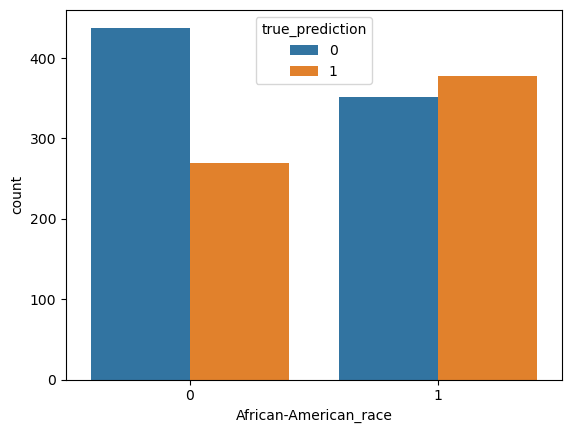

In [36]:
#order = sorted(data[col].unique())
sns.countplot(data=X_test, x='African-American_race', hue = 'true_prediction')

Model Prediction for African Amerian

<AxesSubplot:xlabel='African-American_race', ylabel='count'>

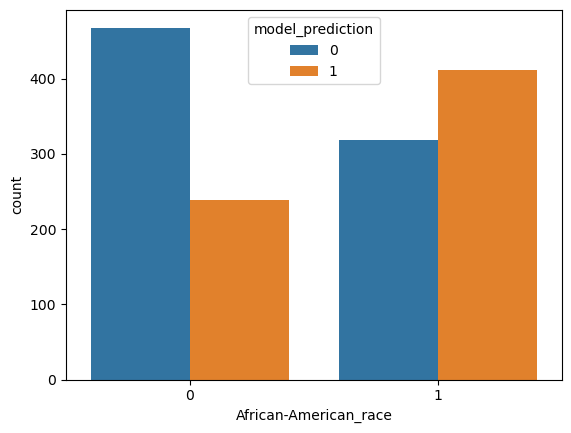

In [37]:
#order = sorted(data[col].unique())
sns.countplot(data=X_test, x='African-American_race', hue = 'model_prediction')

**Note:** We can observe clear bias towards this race

<AxesSubplot:xlabel='Other_race', ylabel='count'>

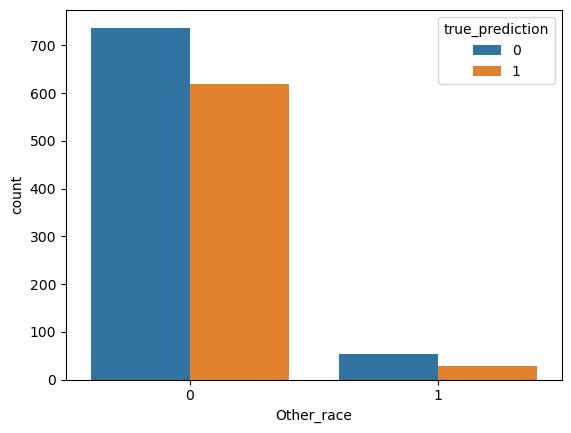

In [38]:
#order = sorted(data[col].unique())
sns.countplot(data=X_test, x='Other_race', hue = 'true_prediction')

<AxesSubplot:xlabel='Other_race', ylabel='count'>

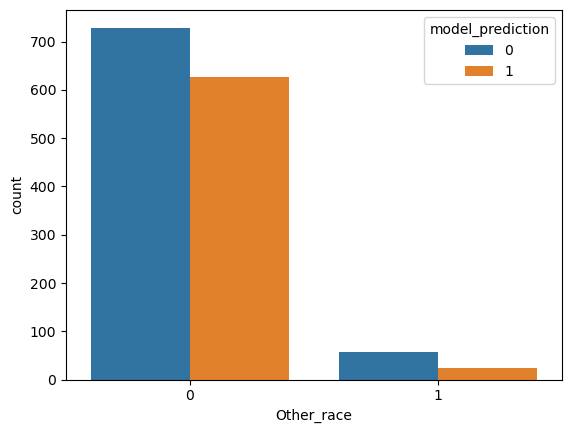

In [39]:
#order = sorted(data[col].unique())
sns.countplot(data=X_test, x='Other_race', hue = 'model_prediction')

This is balanced

<H1>FAIRNESS</H1> 

<h2>Evaluating fairness of the baseline model</h2>

In our case, sensitive attributes are gender and race. Therefore analysing the fairness metrics for these groups on below metrics:

In [40]:
#importing relevant packages related to Fair ML/AI
import aif360
import holisticai
from aif360.datasets import BinaryLabelDataset
# holisticai imports
from holisticai.bias.metrics import classification_bias_metrics
from holisticai.bias.metrics import statistical_parity
from holisticai.bias.metrics import false_positive_rate_diff
from holisticai.bias.metrics import equal_opportunity_diff
from holisticai.bias.metrics import average_odds_diff
from holisticai.bias.metrics import disparate_impact

<h3> We will check bias of baseline model against two sensitve variables sex and race.</h3>

<AxesSubplot:xlabel='sex', ylabel='count'>

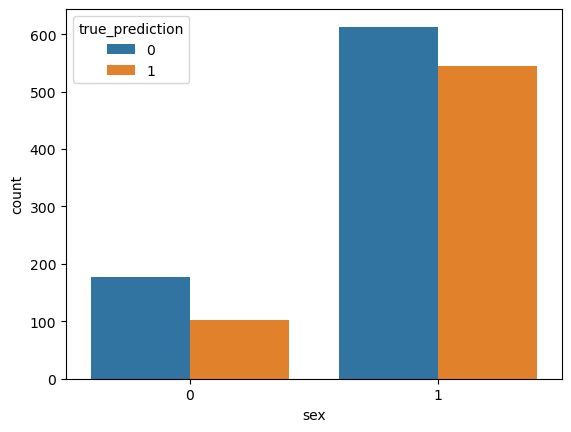

In [41]:
#order = sorted(data[col].unique())
sns.countplot(data=X_test, x='sex', hue = 'true_prediction')

<AxesSubplot:xlabel='sex', ylabel='count'>

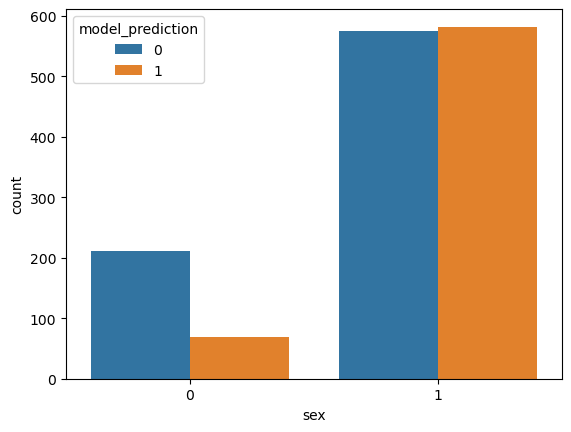

In [42]:
#order = sorted(data[col].unique())
sns.countplot(data=X_test, x='sex', hue = 'model_prediction')

Note: Evident bias against gender male

* checking probability distribution across genders

<Figure size 1000x600 with 0 Axes>

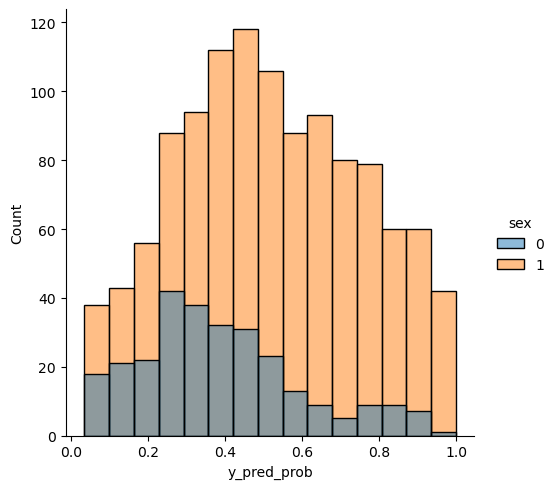

In [43]:
sex_prob_dist_df= pd.merge(predictions_df,X_test['sex'],left_index=True, right_index=True)
plt.figure(figsize=(10,6))
sns.displot(sex_prob_dist_df, x= 'y_pred_prob', hue='sex')

Checking the performance of the baseline model on the below metrics:
1. Statistical Parity : Comparing the Positive Prediction Rate/Precision across groups. i.e. comparing the actual postives against the predicted postives. i.e out of model's postive predictions, how many actually reoffended. A fair model should not have too low of a PPR for sensitive groups since that indicates that model unfairly predicts that many people would reoffend, compred to what aftually did
2. Equal Opportunity : What is the probability that an actual poitive will test positive, i.e. an actual reoffender will be classified as a reoffender? We will compare TPR across groups to compare this. Model should not have too low of a TPR for previledged groups
3. <b>False Positive Rate Disparity : difference across groups in the probability of falsely predicting the reoffence, when they didnt commit one. This will be the metric we will be trying to control going forward, to avoid falsly accusing innocents, and be fair across groups</b> 

<I>Note that the negative values of these metrics are due tot he fact that the metrics are defined considering '1' as 'favorable' outcome and '0' as unfavorable outcome, hence we will be taking negative signs of those and inverting the ratio metrics to keep the results intuitive and inline with thier usual meanings

In [44]:
gender_group_female = X_test['sex'] == 0
gender_group_male = X_test['sex'] == 1

<b>1. Statistical parity:</b>

In [45]:
abs(statistical_parity(gender_group_female,gender_group_male,y_pred_test))

0.2565964933942462

Statistical parity is positive. Meaning the model is biased against gender_group_male. It should be as close to 0 as possible.
We will try to verify it below

In [46]:
positive_pred_sex_df = X_test[X_test['model_prediction'] == 1] #taking positive predictions
Positive_pred_rate_sex_df = positive_pred_sex_df.groupby('sex')['model_prediction','true_prediction'].sum().rename(columns={'model_prediction': 'positive_prediction', 'true_prediction': 'true_prediction'})
Positive_pred_rate_sex_df['PPR'] = Positive_pred_rate_sex_df['true_prediction']/Positive_pred_rate_sex_df['positive_prediction']
Positive_pred_rate_sex_df

,positive_prediction,true_prediction,PPR
sex,,,
0,69,49,0.710145
1,582,383,0.658076


very slight bias in terms of disriminating over gender as per statistical Parity

<b> 2. Equal opportunity : is there differene in Recall across gender groups? That means, out of all the true reoffenders across groups, are we eually likely to predict the chances of reoffence for all the groups? </b>


If we are fair, metric would be 0 , meaning equally likely to predict positive from actual positives across groups. more the deviation, more unfair we are

In [47]:
abs(equal_opportunity_diff(gender_group_female,gender_group_male,y_pred_test,y_test))

0.22831596230725304

Model is slightly unfair towards male group. Let us verify by calculating recall across gender groups

In [48]:
positive_act_sex_df = X_test[X_test['true_prediction'] == 1] #taking positive actuals
true_pos_rate_sex_df = positive_act_sex_df.groupby('sex')['model_prediction','true_prediction'].sum().rename(columns={'model_prediction': 'positive_prediction', 'true_prediction': 'true_prediction'})
true_pos_rate_sex_df['TPR'] = true_pos_rate_sex_df['positive_prediction']/true_pos_rate_sex_df['true_prediction']
true_pos_rate_sex_df

,positive_prediction,true_prediction,TPR
sex,,,
0,49,103,0.475728
1,383,544,0.704044


Recall for Males is much much higher than Females

<b>3. False Positive Rate Disparity : Compares FPR, i.e probability of predicting as criminal even when they are not!

In [49]:
abs(false_positive_rate_diff(gender_group_female,gender_group_male,y_pred_test,y_test))

0.21163860240919435

In [50]:
negative_act_sex_df = X_test[X_test['true_prediction'] == 0] #taking negative actuals
fpr_sex_df = negative_act_sex_df.groupby('sex')['model_prediction'].aggregate(['sum','count']).rename(columns={'sum': 'positive_prediction', 'count': 'actual_negatives'})
fpr_sex_df['FPR'] = fpr_sex_df['positive_prediction']/fpr_sex_df['actual_negatives']
fpr_sex_df

,positive_prediction,actual_negatives,FPR
sex,,,
0,20,177,0.112994
1,199,613,0.324633


[Text(0, 0, '0.112994'), Text(0, 0, '0.324633')]

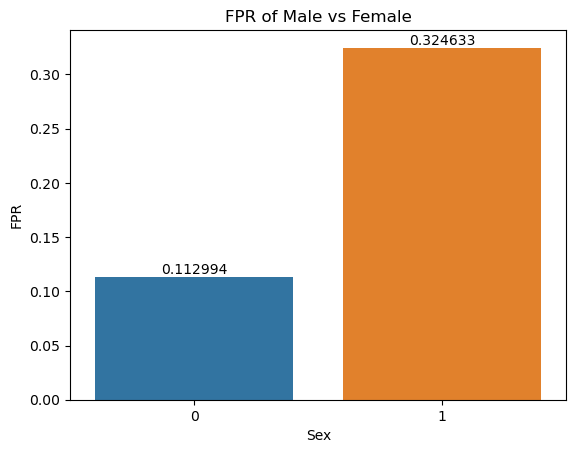

In [51]:
plt.figure()
ax = sns.barplot(x = fpr_sex_df.index, y = fpr_sex_df['FPR'])
plt.title("FPR of Male vs Female")
plt.xlabel("Sex")
plt.ylabel("FPR")
ax.bar_label(ax.containers[0])

Males are more likely to be predicted as reoffenders even when they are not. 

<h3> doing similar analysis for race </h3>

In [52]:
X_test.columns

Index(['id', 'sex', 'age', 'juv_fel_count', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'c_charge_desc',
       'time_in_custody_in_days', 'time_in_jail_in_days',
       'African-American_race', 'Asian_race', 'Caucasian_race',
       'Hispanic_race', 'Native American_race', 'Other_race',
       'Felony_c_charge_degree', 'Misdemeanor_c_charge_degree',
       'High_score_text', 'Low_score_text', 'Medium_score_text',
       'High_v_score_text', 'Low_v_score_text', 'Medium_v_score_text',
       'model_prediction', 'true_prediction'],
      dtype='object')

In [53]:
race_df = pd.merge(X_test[['sex','African-American_race','Asian_race','Caucasian_race','Hispanic_race', 'Native American_race', 'Other_race']],predictions_df,left_index=True,right_index=True)
race_df['sex'] =  race_df['sex'].astype("category")
race_df['African-American_race'] =  race_df['African-American_race'].astype("category")
race_df['Asian_race'] = race_df['Asian_race'].astype("category")
race_df['Caucasian_race'] = race_df['Caucasian_race'].astype("category")
race_df['Hispanic_race'] =  race_df['Hispanic_race'].astype("category")
race_df['Native American_race'] =  race_df['Native American_race'].astype("category")
race_df['Other_race'] =  race_df['Other_race'].astype("category")

In [54]:
fairness_eval_race_df = pd.DataFrame(columns=['column','fprd'])


In [55]:
y_pred = race_df['y_pred_labels']
y_true = race_df['y_true_labels']
for col in race_df.columns[0:7]:
	print(col)
	privileged_group = race_df[col] == 0
	unprivileged_group = race_df[col] == 1
	fpr_diff = false_positive_rate_diff(unprivileged_group,privileged_group,y_pred,y_true)
	print(col, fpr_diff)

sex
sex 0.21163860240919435
African-American_race
African-American_race 0.1609978206724782
Asian_race
Asian_race -0.2796934865900383
Caucasian_race
Caucasian_race -0.13273535220539828
Hispanic_race
Hispanic_race -0.03717100730329337
Native American_race
Native American_race 0.2233502538071066
Other_race
Other_race -0.05445329100637464


In [56]:
privileged_group = race_df['African-American_race'] == 0
unprivileged_group = race_df['African-American_race'] == 1
print(equal_opportunity_diff(unprivileged_group,privileged_group,race_df['y_pred_labels'],race_df['y_true_labels']))

0.19477390295234165


<AxesSubplot:xlabel='African-American_race', ylabel='count'>

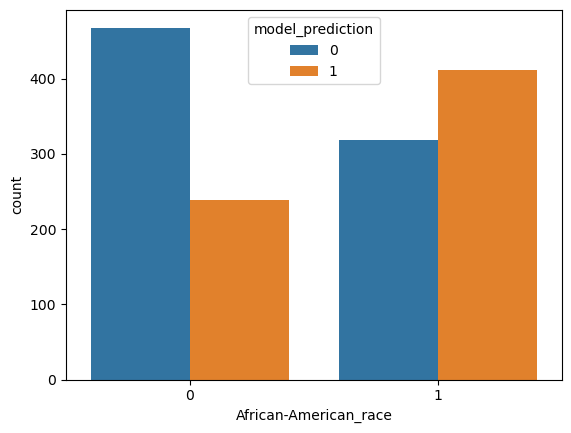

In [57]:
#order = sorted(data[col].unique())
sns.countplot(data=X_test, x='African-American_race', hue = 'model_prediction')

count of unprivileged vs previleged:
 False    1429
True        8
Name: Asian_race, dtype: int64
------------------------------------------------------------
statistical parity :  -0.3298635409377187
equal opportunity diff: 0.33281733746130027
fprd : -0.2796934865900383
dpi : 0.2748076923076923



<Figure size 1000x600 with 0 Axes>

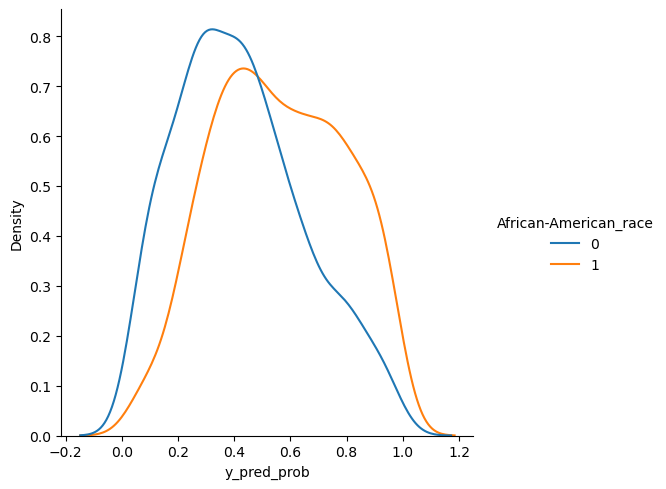

In [58]:
plt.figure(figsize=(10,6))
sns.displot(race_df, x= 'y_pred_prob', hue='African-American_race',kind='kde')
privileged_group = race_df['Asian_race'] == 0
unprivileged_group = race_df['Asian_race'] == 1
y_pred = race_df['y_pred_labels']
y_true = race_df['y_true_labels']
print("count of unprivileged vs previleged:\n",unprivileged_group.value_counts())
print("------------------------------------------------------------")
sp = statistical_parity(unprivileged_group,privileged_group,y_pred)
print("statistical parity : ", sp)
eod = equal_opportunity_diff(unprivileged_group,privileged_group,y_pred,y_true)
print("equal opportunity diff:", eod)
fprd = false_positive_rate_diff(unprivileged_group,privileged_group,y_pred,y_true)
print("fprd :",fprd )
dpi = disparate_impact(unprivileged_group,privileged_group,y_pred)
print("dpi :",dpi )

print()

In [59]:
negative_act_amrace_df = X_test[X_test['true_prediction'] == 0] #taking negative actuals

In [60]:
negative_act_amrace_df = X_test[X_test['true_prediction'] == 0] #taking negative actuals
fpr_am_race_df = negative_act_amrace_df.groupby('African-American_race')['model_prediction'].aggregate(['sum','count']).rename(columns={'sum': 'positive_prediction', 'count': 'actual_negatives'})
fpr_am_race_df['FPR'] = fpr_am_race_df['positive_prediction']/fpr_am_race_df['actual_negatives']
fpr_am_race_df

,positive_prediction,actual_negatives,FPR
African-American_race,,,
0,90,438,0.205479
1,129,352,0.366477


[Text(0, 0, '0.205479'), Text(0, 0, '0.366477')]

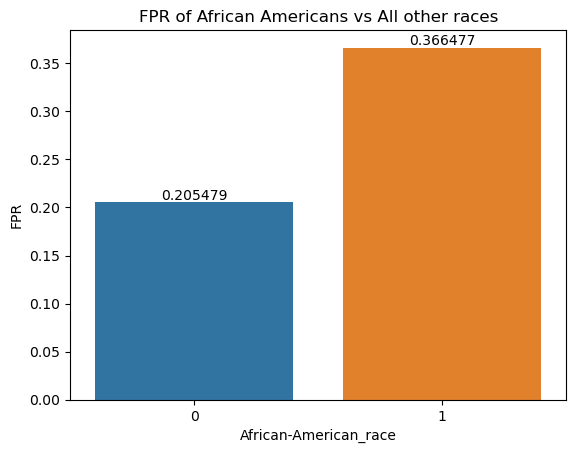

In [61]:
plt.figure()
ax = sns.barplot(x = fpr_am_race_df.index, y = fpr_am_race_df['FPR'])
plt.title("FPR of African Americans vs All other races")
plt.xlabel("African-American_race")
plt.ylabel("FPR")
ax.bar_label(ax.containers[0])

African americans are 16% more likely to be wrongly accused of reoffense

Remarks:
1. FPRs for both gender and African americans is significantly higher compared to previleged groups.
2. As we mititgate this bias, we should expect to see drop in model recall, since we are essentilly reducing the False Positives

<b><h2>  Mitigating the bias

<h4><b>1. In-Processing

- Modifying the data to reduce the bias in the model. 
1. Resampling :  We can resample the minority groups to make representation more fair, but in our case it is not advisable to generate aretififal samples due to the nature of the data and problem statement at hand
2. Reweighting : We will re-weight the data- minority samples in particular to increase their representation. 